In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.model_selection import train_test_split

In [38]:
#reading data1 csv file - processed data due to Ram limitation
df=pd.read_csv('data1.csv')

In [3]:
# verifiying upload
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15927485 entries, 0 to 15927484
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   fl_date             object 
 1   mkt_unique_carrier  object 
 2   origin              object 
 3   dest                object 
 4   arr_delay           float64
 5   cancelled           int64  
 6   distance            int64  
 7   weather_delay       float64
 8   month               int64  
 9   month_day           int64  
 10  week_day            int64  
 11  dep_hour            float64
 12  arr_hour            float64
dtypes: float64(4), int64(5), object(4)
memory usage: 1.5+ GB


In [6]:
# looking for column index
print(df.columns)

Index(['fl_date', 'mkt_unique_carrier', 'origin', 'dest', 'arr_delay',
       'cancelled', 'distance', 'weather_delay', 'month', 'month_day',
       'week_day', 'dep_hour', 'arr_hour'],
      dtype='object')


In [4]:
# looking for missing values
df.isnull().sum()

fl_date                      0
mkt_unique_carrier           0
origin                       0
dest                         0
arr_delay               311744
cancelled                    0
distance                     0
weather_delay         12918001
month                        0
month_day                    0
week_day                     0
dep_hour                  2568
arr_hour                 48937
dtype: int64

In [39]:
# separating data by cancelled flights and non cancelled flight
df_cancelled = df[df['cancelled']==1]
df_non_cancelled=df[df['cancelled']==0]


In [40]:
# # Shuffle the data in the DataFrame and create a balanced sample for cancelled flights
sample_size = len(df_cancelled)
df_cancelled = df_cancelled.sample(n=sample_size, random_state=42)
df_non_cancelled= df_non_cancelled.sample(n=sample_size, random_state=42)
df= pd.concat([df_cancelled,df_non_cancelled])
# # Reset the index of the shuffled sample
df.reset_index(drop=True, inplace=True)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538416 entries, 0 to 538415
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fl_date             538416 non-null  object 
 1   mkt_unique_carrier  538416 non-null  object 
 2   origin              538416 non-null  object 
 3   dest                538416 non-null  object 
 4   arr_delay           268457 non-null  float64
 5   cancelled           538416 non-null  int64  
 6   distance            538416 non-null  int64  
 7   weather_delay       51982 non-null   float64
 8   month               538416 non-null  int64  
 9   month_day           538416 non-null  int64  
 10  week_day            538416 non-null  int64  
 11  dep_hour            538344 non-null  float64
 12  arr_hour            536579 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 53.4+ MB


In [42]:
# missing value in dep hour and arr hour refer to midnight
df=df.fillna(0)

In [43]:
df.head()

,fl_date,mkt_unique_carrier,origin,dest,arr_delay,cancelled,distance,weather_delay,month,month_day,week_day,dep_hour,arr_hour
0,2018-07-24,DL,BNA,JFK,0.0,1,765,0.0,7,24,1,10.0,13.0
1,2019-01-13,B6,DCA,FLL,0.0,1,899,0.0,1,13,6,10.0,13.0
2,2018-03-13,AA,PWM,PHL,0.0,1,364,0.0,3,13,1,10.0,12.0
3,2018-03-06,AA,SWF,PHL,0.0,1,127,0.0,3,6,1,14.0,16.0
4,2019-02-13,WN,HOU,SLC,0.0,1,1214,0.0,2,13,2,7.0,9.0


In [45]:
# creating column with average weaher delay by carrier and removing column weather delay

x= df.groupby('mkt_unique_carrier')['weather_delay'].mean()
df['weather_delay_carrier_mean']= (df['mkt_unique_carrier'].map(x)).round(2)
df=df.drop(['weather_delay'],axis=1)


In [46]:
# creating column with average cancellation by route and removing route column
df['origin-dest']=df['origin']+'-'+df['dest']
x= df.groupby('origin-dest')['cancelled'].mean()
df['origin-dest-mean']= (df['origin-dest'].map(x)).round(2)
df=df.drop(['origin','dest'],axis=1)

In [47]:
# creating column with average cancellation by carrier and month and removing column regrouped columns
df['month']=df['month'].astype(str)
df['month_carrier']=df['mkt_unique_carrier']+'-'+df['month']
x= df.groupby('month_carrier')['cancelled'].mean()
df['month_carrier_mean']= (df['month_carrier'].map(x)).round(2)
df=df.drop(['month_carrier','mkt_unique_carrier','month'],axis=1)

In [48]:
df.head()

,fl_date,arr_delay,cancelled,distance,month_day,week_day,dep_hour,arr_hour,weather_delay_carrier_mean,origin-dest,origin-dest-mean,month_carrier_mean
0,2018-07-24,0.0,1,765,24,1,10.0,13.0,0.75,BNA-JFK,0.70,0.36
1,2019-01-13,0.0,1,899,13,6,10.0,13.0,0.20,DCA-FLL,0.39,0.55
2,2018-03-13,0.0,1,364,13,1,10.0,12.0,0.34,PWM-PHL,0.67,0.64
3,2018-03-06,0.0,1,127,6,1,14.0,16.0,0.34,SWF-PHL,0.77,0.64
4,2019-02-13,0.0,1,1214,13,2,7.0,9.0,0.11,HOU-SLC,0.67,0.67


In [49]:
# removing non selected features
df=df.drop(['fl_date','origin-dest','distance','arr_hour','arr_delay'],axis=1)

In [50]:
df.head()

,cancelled,month_day,week_day,dep_hour,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean
0,1,24,1,10.0,0.75,0.70,0.36
1,1,13,6,10.0,0.20,0.39,0.55
2,1,13,1,10.0,0.34,0.67,0.64
3,1,6,1,14.0,0.34,0.77,0.64
4,1,13,2,7.0,0.11,0.67,0.67


In [20]:
# encoding categories including integers
dummies = ['week_day','month_day','dep_hour'] 

for i in dummies:
    df1 = pd.concat([df, pd.get_dummies(df[i], prefix=i,dtype=float)], axis=1)
    df1 = df.drop([i], axis=1)

In [22]:
#scaling data with StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# Scale features since weight magnitudes will effect regularization weight penalties
scaler = StandardScaler().set_output(transform='pandas')
df_scaled = scaler.fit_transform(df1)
df_scaled.head()

,cancelled,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,...,dep_hour_14.0,dep_hour_15.0,dep_hour_16.0,dep_hour_17.0,dep_hour_18.0,dep_hour_19.0,dep_hour_20.0,dep_hour_21.0,dep_hour_22.0,dep_hour_23.0
0,1.0,1.862871,1.018343,-0.954997,-0.420805,2.393292,-0.437007,-0.418058,-0.40816,-0.350013,...,-0.251971,-0.258387,-0.255009,-0.280882,-0.270919,-0.254938,-0.235018,-0.188734,-0.170305,-0.076012
1,1.0,-0.816237,-0.559860,0.334762,-0.420805,-0.417835,-0.437007,-0.418058,-0.40816,-0.350013,...,-0.251971,-0.258387,-0.255009,-0.280882,-0.270919,-0.254938,-0.235018,-0.188734,-0.170305,-0.076012
2,1.0,-0.134282,0.865614,0.945700,-0.420805,2.393292,-0.437007,-0.418058,-0.40816,-0.350013,...,-0.251971,-0.258387,-0.255009,-0.280882,-0.270919,-0.254938,-0.235018,-0.188734,-0.170305,-0.076012
3,1.0,-0.134282,1.374712,0.945700,-0.420805,2.393292,-0.437007,-0.418058,-0.40816,-0.350013,...,3.968708,-0.258387,-0.255009,-0.280882,-0.270919,-0.254938,-0.235018,-0.188734,-0.170305,-0.076012
4,1.0,-1.254636,0.865614,1.149346,-0.420805,-0.417835,2.288293,-0.418058,-0.40816,-0.350013,...,-0.251971,-0.258387,-0.255009,-0.280882,-0.270919,-0.254938,-0.235018,-0.188734,-0.170305,-0.076012


Predicting cancellation

In [23]:
#Shuffling data and isolating the target
from sklearn.utils import shuffle
X, y = df.drop(['cancelled'],axis=1), df['cancelled']

X, y = shuffle(X, y, random_state=27)

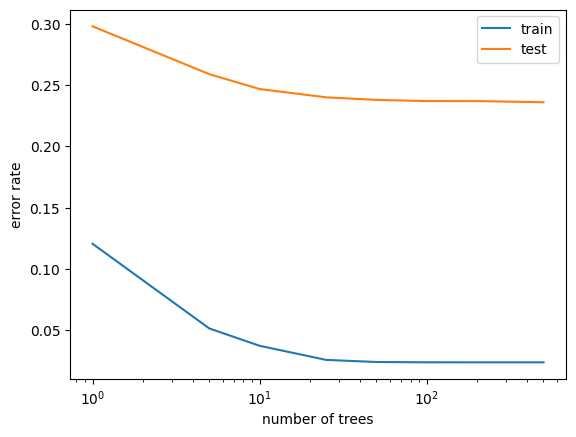

In [ ]:
# selcting n_trees for the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Gather and prepare your data
# Refer to above

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Plots training error and testing error, using various amounts of trees in the random forest.
def make_num_tree_plot(X_train, y_train, X_test, y_test, num_trees):
    train_err = []
    test_err = []
    for ntree in num_trees:
        model = RandomForestClassifier(n_estimators=ntree)
        model.fit(X_train, y_train)
        train_err.append(1-model.score(X_train, y_train))
        test_err.append(1-model.score(X_test, y_test))

    fig, ax = plt.subplots()
    ax.plot(num_trees,train_err,label="train")
    ax.plot(num_trees,test_err,label="test")
    ax.set_xlabel('number of trees');
    ax.set_ylabel('error rate');
    ax.set_xscale('log')
    ax.legend()
    plt.show()

#fit a random forest for various n_estimators and plot the error
make_num_tree_plot(X_train, y_train, X_test, y_test, (1,5,10,25,50,100,200,500))

In [24]:
# Running the model with n=5

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=5)
model.fit(X_train, y_train)

# Calculate the training accuracy
train_accuracy = model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Calculate the testing accuracy
test_accuracy = model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9489729112301849
Testing Accuracy: 0.7439081014821143


Classification Report (Default Threshold):
              precision    recall  f1-score   support

           0       0.74      0.75      0.74     53825
           1       0.74      0.74      0.74     53859

    accuracy                           0.74    107684
   macro avg       0.74      0.74      0.74    107684
weighted avg       0.74      0.74      0.74    107684



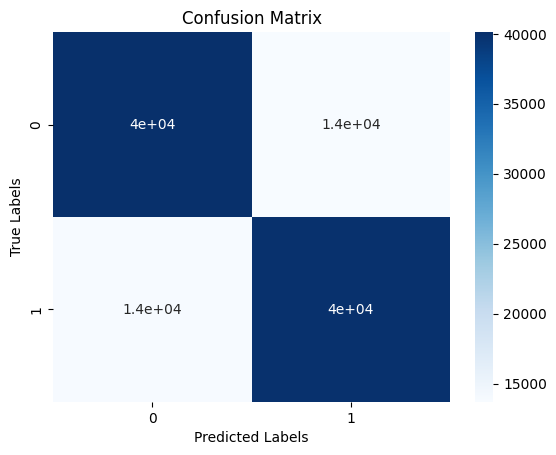

[8.16337423e-02 3.71813842e-01 1.46322926e-01 1.25353062e-02
 1.14955005e-02 9.64615506e-03 1.28508248e-02 1.03587687e-02
 6.53450035e-03 1.21474830e-02 5.76521218e-03 7.19394351e-03
 6.13598576e-03 5.85421110e-03 4.24797298e-03 4.21435149e-03
 5.68354787e-03 5.69540116e-03 6.39207146e-03 6.70997705e-03
 6.23675787e-03 5.32814678e-03 6.36865335e-03 6.64346391e-03
 5.83878599e-03 6.06915762e-03 5.46057156e-03 6.00790292e-03
 4.39364912e-03 5.14207116e-03 5.90773002e-03 6.60551747e-03
 5.87725273e-03 5.98537169e-03 5.97586266e-03 5.59473668e-03
 5.55877375e-03 7.03914674e-03 7.22130017e-03 6.84544747e-03
 4.73048853e-03 8.65971987e-05 1.07405943e-04 2.07865962e-04
 2.84090496e-04 1.90002759e-04 6.25922611e-03 1.15635360e-02
 9.47590200e-03 9.05903378e-03 6.96904761e-03 8.86915146e-03
 7.17635915e-03 8.35078660e-03 8.40762122e-03 8.85557741e-03
 9.28050968e-03 8.75895001e-03 6.13098538e-03 5.26445861e-03
 5.52719708e-03 5.87787602e-03 6.89994479e-03 6.28069192e-03
 2.05467099e-03]


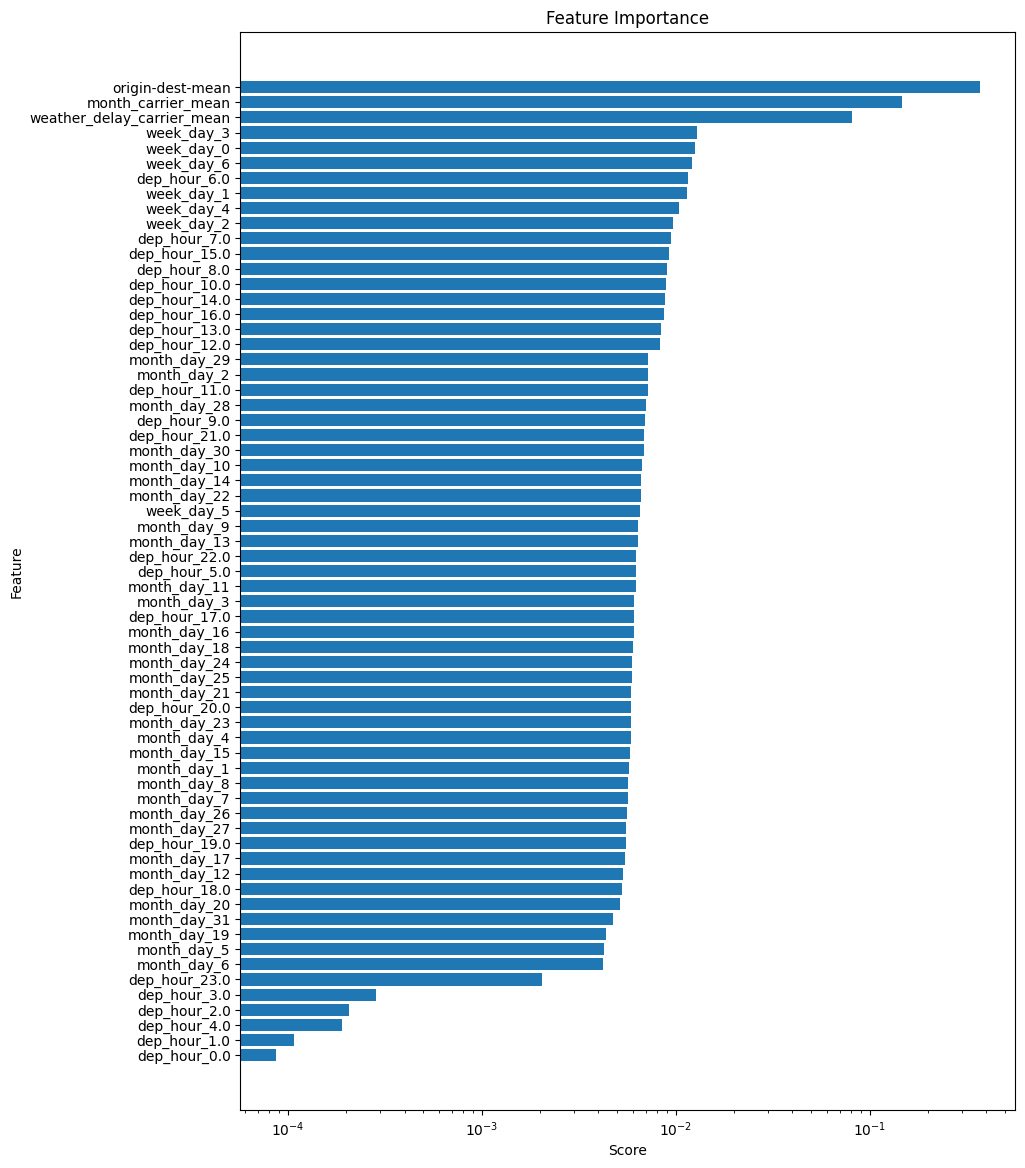

In [25]:
# Make predictions on the testing data
y_pred = model.predict(X_test)
#Classification Report
print("Classification Report (Default Threshold):")
print(classification_report(y_test, y_pred))
# Plot the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# #feature importance score and plot them
feature_importance = model.feature_importances_
print(feature_importance)

# Create a horizontal bar plot to visualize the feature importance scores
plt.figure(figsize=(10, 14))

# Sort the feature importance scores and corresponding feature names
sorted_indices = np.argsort(feature_importance)
sorted_features = X_train.columns[sorted_indices]
sorted_scores = feature_importance[sorted_indices]

plt.barh(sorted_features, sorted_scores)
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Change the x-axis scale to logarithmic
plt.xscale('log')

plt.show()

plt.show()

In [51]:
# Reading Flight_test_processed

X_new= pd.read_csv('Flight_test_processed.csv')

X_new.head()

,fl_date,mkt_unique_carrier,origin,dest,month_day,week_day,dep_hour,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean
0,2020-01-01 00:00:00,WN,ONT,SFO,1,2,18.0,1.41,0.03,0.02
1,2020-01-01 00:00:00,WN,ONT,SFO,1,2,11.0,1.41,0.03,0.02
2,2020-01-01 00:00:00,WN,ONT,SJC,1,2,20.0,1.41,0.01,0.02
3,2020-01-01 00:00:00,WN,ONT,SJC,1,2,13.0,1.41,0.01,0.02
4,2020-01-01 00:00:00,WN,ONT,SJC,1,2,9.0,1.41,0.01,0.02


In [52]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660556 entries, 0 to 660555
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   fl_date                     660556 non-null  object 
 1   mkt_unique_carrier          660556 non-null  object 
 2   origin                      660556 non-null  object 
 3   dest                        660556 non-null  object 
 4   month_day                   660556 non-null  int64  
 5   week_day                    660556 non-null  int64  
 6   dep_hour                    660556 non-null  float64
 7   weather_delay_carrier_mean  660556 non-null  float64
 8   origin-dest-mean            660556 non-null  float64
 9   month_carrier_mean          660556 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 50.4+ MB


In [53]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538416 entries, 0 to 538415
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   cancelled                   538416 non-null  int64  
 1   month_day                   538416 non-null  int64  
 2   week_day                    538416 non-null  int64  
 3   dep_hour                    538416 non-null  float64
 4   weather_delay_carrier_mean  538416 non-null  float64
 5   origin-dest-mean            538416 non-null  float64
 6   month_carrier_mean          538416 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 28.8 MB


In [54]:
# preparing data for same dummies process including Unseen dat
X=df.drop('cancelled',axis=1)

In [55]:
# removing non required column for the model
X_final_data=X_new.drop(['fl_date','mkt_unique_carrier','origin','dest'],axis=1)
X_final_data.head()

,month_day,week_day,dep_hour,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean
0,1,2,18.0,1.41,0.03,0.02
1,1,2,11.0,1.41,0.03,0.02
2,1,2,20.0,1.41,0.01,0.02
3,1,2,13.0,1.41,0.01,0.02
4,1,2,9.0,1.41,0.01,0.02


In [56]:
#Merging both df for same dummies process
X_all=pd.concat([X,X_final_data])

In [57]:
# adding dummies
dummies = ['week_day','month_day','dep_hour'] 

for i in dummies:
    X_all = pd.concat([X_all, pd.get_dummies(X_all[i], prefix=i,dtype=float)], axis=1)
    X_all = X_all.drop([i], axis=1)

In [58]:
# scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# Scale features since weight magnitudes will effect regularization weight penalties
scaler = StandardScaler().set_output(transform='pandas')
X_all_scaled = scaler.fit_transform(X_all)
X_all_scaled.head()

,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,...,dep_hour_14.0,dep_hour_15.0,dep_hour_16.0,dep_hour_17.0,dep_hour_18.0,dep_hour_19.0,dep_hour_20.0,dep_hour_21.0,dep_hour_22.0,dep_hour_23.0
0,-0.694037,1.699955,0.481977,-0.407254,2.516622,-0.436176,-0.43772,-0.433574,-0.349006,-0.393237,...,-0.252742,-0.255537,-0.252032,-0.273199,-0.259505,-0.246593,-0.227803,-0.183682,-0.160893,-0.08016
1,-0.951636,0.570033,1.214110,-0.407254,-0.397358,-0.436176,-0.43772,-0.433574,-0.349006,2.542997,...,-0.252742,-0.255537,-0.252032,-0.273199,-0.259505,-0.246593,-0.227803,-0.183682,-0.160893,-0.08016
2,-0.886065,1.590607,1.560910,-0.407254,2.516622,-0.436176,-0.43772,-0.433574,-0.349006,-0.393237,...,-0.252742,-0.255537,-0.252032,-0.273199,-0.259505,-0.246593,-0.227803,-0.183682,-0.160893,-0.08016
3,-0.886065,1.955098,1.560910,-0.407254,2.516622,-0.436176,-0.43772,-0.433574,-0.349006,-0.393237,...,3.956602,-0.255537,-0.252032,-0.273199,-0.259505,-0.246593,-0.227803,-0.183682,-0.160893,-0.08016
4,-0.993788,1.590607,1.676510,-0.407254,-0.397358,2.292650,-0.43772,-0.433574,-0.349006,-0.393237,...,-0.252742,-0.255537,-0.252032,-0.273199,-0.259505,-0.246593,-0.227803,-0.183682,-0.160893,-0.08016


In [76]:
# spliting data
X=X_all_scaled[:538416]
X_new_scaled = X_all_scaled[538416:]

y= df[['cancelled']]


In [77]:
# retraining the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=5)
model.fit(X_train, y_train)

# Calculate the training accuracy
train_accuracy = model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

# Calculate the testing accuracy
test_accuracy = model.score(X_test, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.949202752523611
Testing Accuracy: 0.7399892277404256


In [78]:
# Make predictions on the testing data
y_final_pred = model.predict(X_new_scaled)


# Convert y_final_pred to a pandas Series
y_final_pred_series = pd.Series(y_final_pred)
# adding the prediction to the initial data Frame
X_new['predicted_cancellation']=y_final_pred_series

In [79]:
X_new.head()

,fl_date,mkt_unique_carrier,origin,dest,month_day,week_day,dep_hour,weather_delay_carrier_mean,origin-dest-mean,month_carrier_mean,predicted_cancellation
0,2020-01-01 00:00:00,WN,ONT,SFO,1,2,18.0,1.41,0.03,0.02,-1.0
1,2020-01-01 00:00:00,WN,ONT,SFO,1,2,11.0,1.41,0.03,0.02,-1.0
2,2020-01-01 00:00:00,WN,ONT,SJC,1,2,20.0,1.41,0.01,0.02,-1.0
3,2020-01-01 00:00:00,WN,ONT,SJC,1,2,13.0,1.41,0.01,0.02,-1.0
4,2020-01-01 00:00:00,WN,ONT,SJC,1,2,9.0,1.41,0.01,0.02,-1.0


In [85]:
# changing -1 value no cancellation to 0
X_new.loc[X_new['predicted_cancellation'] == -1, 'predicted_cancellation'] = 0
X_new['predicted_cancellation'] = X_new['predicted_cancellation'].astype(int)

In [88]:
#calculation total predicted cancelled flights
X_new['predicted_cancellation'].value_counts()


predicted_cancellation
0    659380
1      1176
Name: count, dtype: int64

In [92]:
# Prediction file
X_new.to_csv('sample_submission_cancellation.csv', index=False)